## Assignment 2: Set up the work for data-driven inference based on CitiBike data
###### Author: Daniel Fay
   * Write a Jupyter Notebook on compute. This will require you to use the JupyterHub (instructions here ). Write a notebook thats states the question you want to ask, and formulates the Null and Alternative hypothesis (remember the confidence level!)
   * Use pandas to read in the CitiBike files, either from the DF, or locally, but you must be able to download them on the spot (so the TA can reproduce your work).
   * Display the top few rows of the DF in your notebook. This table must be rendered.
   * Display the reducted dataframe. This table must be rendered.
   * Plot your data distributions.

### Idea:
#### Riders over the age of 30 take longer duration bicycle trips

### Null Hypothesis:
#### Bicyclists over the age of 30 average trip duration is shorter than or equal to bicyclists 30 and under

#### _$H_0$_ : $ TripTime_{\mathrm{over30}} <= TripTime_{\mathrm{30orunder}}$
#### _$H_1$_ : $ TripTime_{\mathrm{over30}} > TripTime_{\mathrm{30orunder}}$


#### Significance Level:  $\alpha=0.05$

In [84]:
# Import necessary packages and get environment variables
import os
import numpy as np
import pandas as pd
import math
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

os.getenv('PUIDATA')

'/home/cusp/df1383/PUIdata'

In [85]:
# Wrangle Citibike Data (code used from Federica's sample notebook)
def get_citibike_data(date):
    os.system("curl -O https://s3.amazonaws.com/tripdata/" + date + "-citibike-tripdata.zip")
    os.system("unzip " + date + "-citibike-tripdata.zip")

date = '201606'
get_citibike_data(date)

In [86]:
# Read in CSV file into pandas dataframe and display top 10 rows
df = pd.read_csv(date+'-citibike-tripdata.csv')
df.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1470,6/1/2016 00:00:18,6/1/2016 00:24:48,380,W 4 St & 7 Ave S,40.734011,-74.002939,3236,W 42 St & Dyer Ave,40.758985,-73.993800,19859,Subscriber,1972.0,1
1,229,6/1/2016 00:00:20,6/1/2016 00:04:09,3092,Berry St & N 8 St,40.719009,-73.958525,3103,N 11 St & Wythe Ave,40.721533,-73.957824,16233,Subscriber,1967.0,1
2,344,6/1/2016 00:00:21,6/1/2016 00:06:06,449,W 52 St & 9 Ave,40.764618,-73.987895,469,Broadway & W 53 St,40.763441,-73.982681,22397,Subscriber,1989.0,1
3,1120,6/1/2016 00:00:28,6/1/2016 00:19:09,522,E 51 St & Lexington Ave,40.757148,-73.972078,401,Allen St & Rivington St,40.720196,-73.989978,16231,Subscriber,1991.0,1
4,229,6/1/2016 00:00:53,6/1/2016 00:04:42,335,Washington Pl & Broadway,40.729039,-73.994046,285,Broadway & E 14 St,40.734546,-73.990741,15400,Subscriber,1989.0,1


In [87]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [88]:
# Drop unnecessary columns
df.drop(['starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype','gender'],axis=1,inplace=True)

df.head()

,tripduration,birth year
0,1470,1972.0
1,229,1967.0
2,344,1989.0
3,1120,1991.0
4,229,1989.0


In [89]:
# Create Age column, drop birth year column and clean out outliers (ages over 95)
df['age'] = 2016 - df['birth year']
df.drop(['birth year'],axis=1,inplace=True)
df = df[df['age'] <= 100]
df.head()

,tripduration,age
0,1470,44.0
1,229,49.0
2,344,27.0
3,1120,25.0
4,229,27.0


In [90]:
# Seperate dataframe into over and under 30 dataframes
df_under30 = df[df['age'] <= 30]
df_under30.drop('age',axis=1,inplace=True)

df_over30 = df[df['age'] > 30]
df_over30.drop('age',axis=1,inplace=True)

# Convert trip duration from seconds to minutes and eliminate outliers (trips longer than 8 hours)
df_under30 = df_under30/60
df_under30 = df_under30[df_under30['tripduration'] < 480]

df_over30 = df_over30/60
df_over30 = df_over30[df_over30['tripduration'] < 480]
print (len(df_under30),len(df_over30))

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


382471 881617


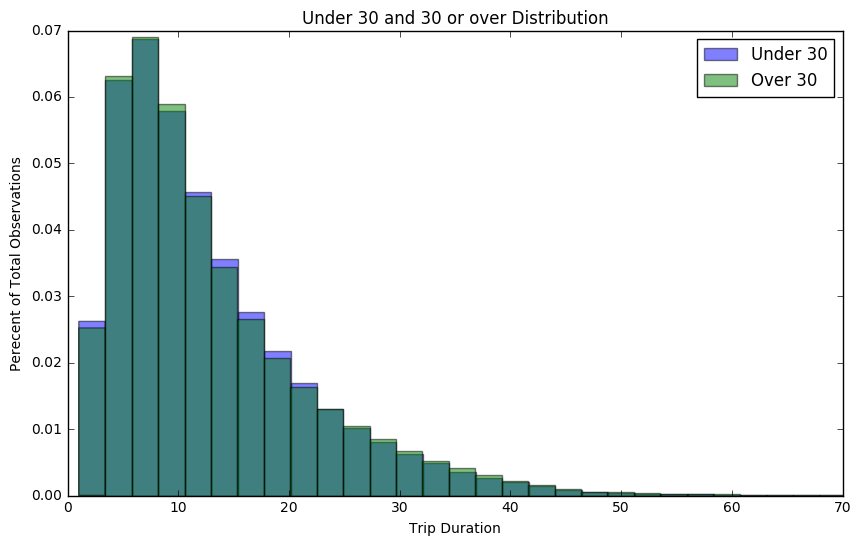

In [91]:
# Plot Distribution of trip duration for riders under 30 and 30 and over
plt.figure(figsize=(10,6))
plt.hist(df_under30['tripduration'],bins=200,alpha=0.5 ,normed=True, label = 'Under 30')
plt.hist(df_over30['tripduration'],bins=200,alpha=0.5, normed=True, label = 'Over 30')
plt.xlim(0,70)
plt.title('Under 30 and 30 or over Distribution')
plt.ylabel('Perecent of Total Observations')
plt.xlabel('Trip Duration')
plt.legend(loc='upper right')

#### Figure 1: Comparison of Normalized Distributions of Cyclists over 30 and 30 or over

In [94]:
# Calculate Z Score and P Value (Right Sided Test)
def z_score(s1,s2):
    s1_mean = np.mean(s1)
    s2_mean = np.mean(s2)
    s1_std = np.std(s2)
    s2_std = np.std(s2)
    n1 = len(s1)
    n2 = len(s2)
    print (s1_mean,s2_mean)
    return (s1_mean-s2_mean)/(np.sqrt(((s2_std**2)/(n2))+((s1_std**2)/(n1))))
                              
z_score = z_score(df_over30['tripduration'],df_under30['tripduration'])
p_value = st.norm.sf(abs(z_score))
print ('Z Score: ', z_score)
print('P Value: ', p_value)

13.1617905697 12.9685499031
Z Score:  8.98221967505
P Value:  1.32679187797e-19


#### Interpretation:
A right sided Z test of the hypothesis resulted in a Z Score of 8.98, which corresponds to a P Value of 1.33e-19. Therefore since the p value is smaller than the stated significance level of .05 we can reject the null hypothesis and accept the alternative.
